## 8. WAV 파일 신호 대 잡음비(SNR) 분석


📈 클래스별 SNR 통계 (dB):
                                             count       mean       std  \
class_label                                                               
1.Car/1.horn_of_car                         3588.0  31.195841  3.369651   
1.Car/2.siren_of_car                        2239.0  30.618294  2.355487   
1.Car/3.driving_sound_of_car                1909.0  29.918000  1.293650   
2.Motorcycle/4.horn_of_motorcycle           5079.0  30.535137  3.501150   
2.Motorcycle/5.driving_sound_of_motorcycle  5233.0  31.227479  1.770007   

                                                  min        25%        50%  \
class_label                                                                   
1.Car/1.horn_of_car                         25.355382  28.824076  30.264201   
1.Car/2.siren_of_car                        25.134955  29.036830  30.044824   
1.Car/3.driving_sound_of_car                26.551522  28.991616  29.683666   
2.Motorcycle/4.horn_of_motorcycle           25.680119  28.

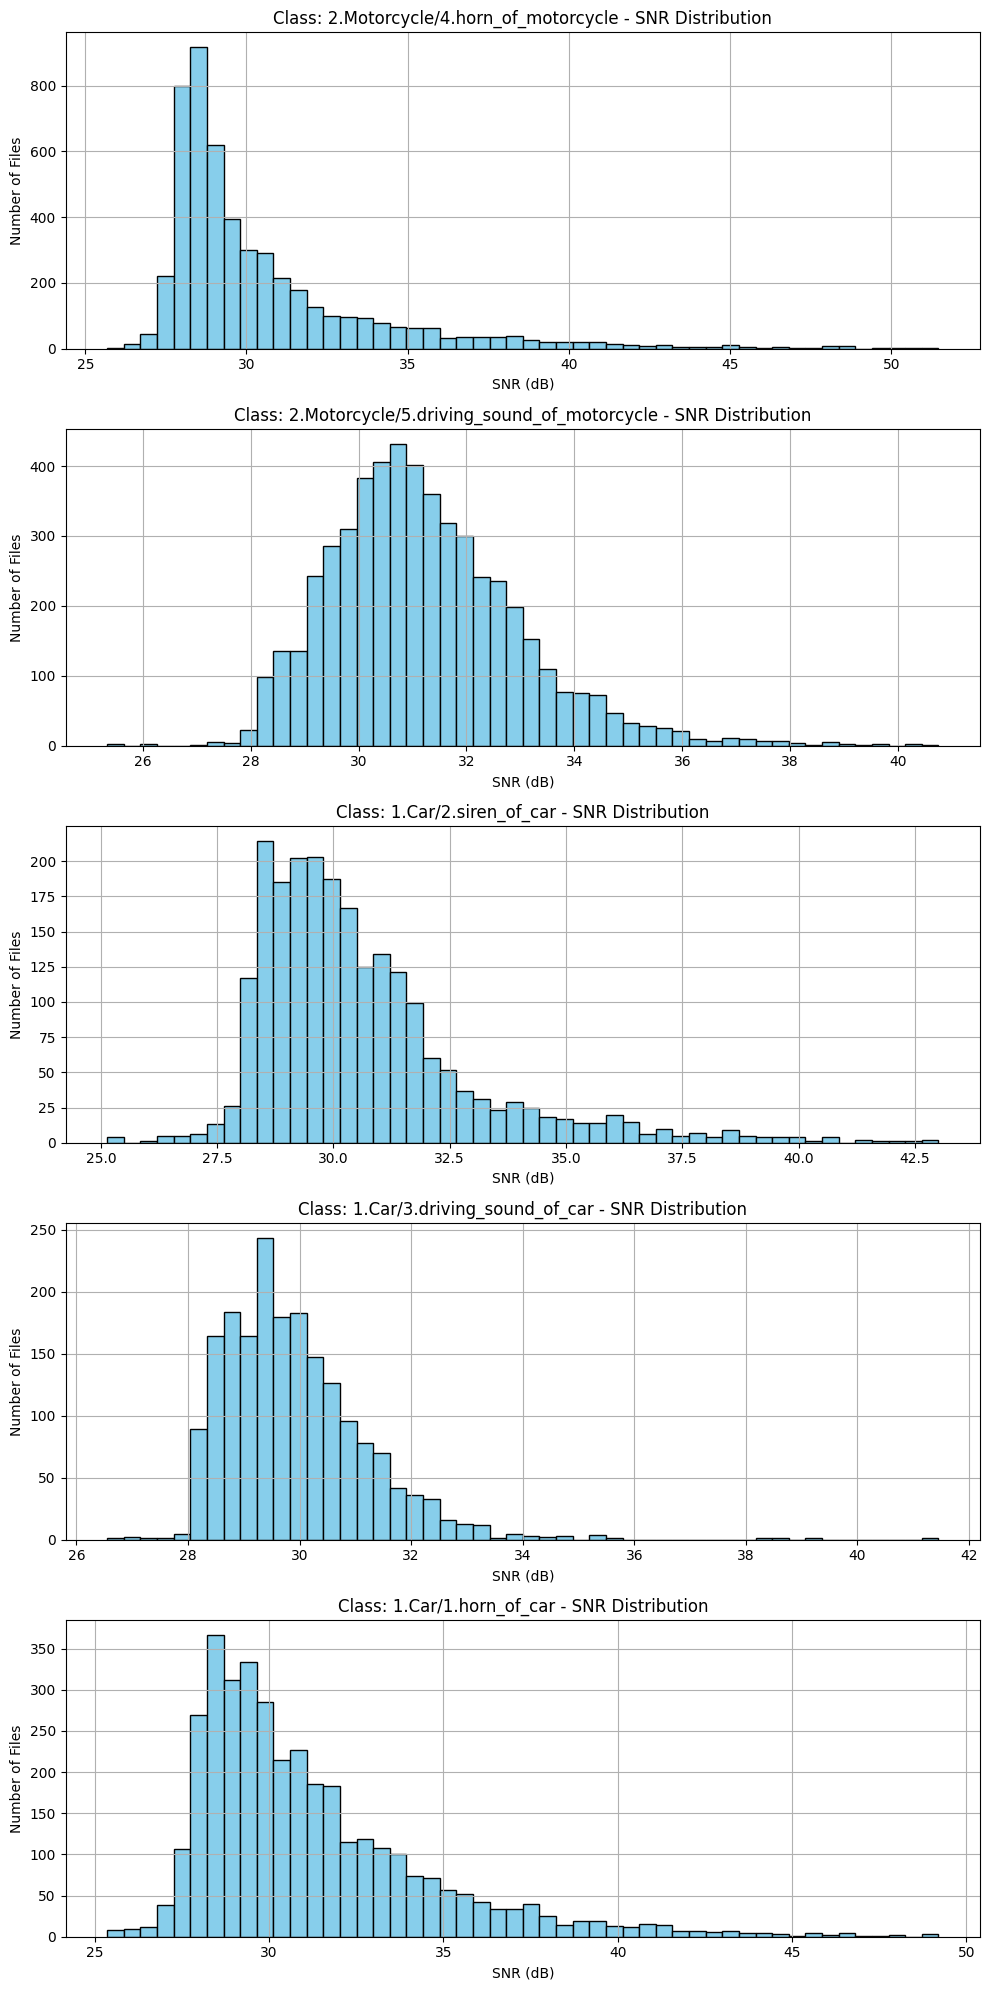


SNR이 5 dB 이하인 파일 수: 0

SNR이 낮은 파일 목록 (최대 10개):


In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 분석할 WAV 파일이 위치한 상위 디렉토리
data_dir = "/home/ubuntu/data"

# 파일 정보를 저장할 리스트
file_info_list = []

# 검사할 파일 확장자
audio_extensions = [".wav"]

# SNR 임계값 설정 (예시: 5 dB 이하 품질 저하)
snr_threshold = 5  # dB

# WAV 파일 검사
for root, _, files in os.walk(data_dir):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(root, file)
            try:
                # librosa로 파일 로드하여 오디오 데이터 및 샘플링 레이트 획득
                y, sr = librosa.load(file_path, sr=None, mono=True)
                
                # 신호의 전체 RMS 계산
                rms_total = np.sqrt(np.mean(y ** 2))
                
                # 무음 구간을 감지하여 배경 소음 추정
                silent_threshold = np.median(np.abs(y)) * 0.1  # 조정 가능
                non_silent_indices = np.where(np.abs(y) > silent_threshold)[0]
                silent_indices = np.where(np.abs(y) <= silent_threshold)[0]

                if len(silent_indices) == 0:
                    # 무음 구간이 없을 경우 배경 소음을 추정할 수 없음
                    snr = None
                else:
                    # 배경 소음 RMS 계산
                    noise_rms = np.sqrt(np.mean(y[silent_indices] ** 2))

                    # SNR 계산
                    snr = 20 * np.log10((rms_total + 1e-6) / (noise_rms + 1e-6))
                
                # 클래스 정보 추출 (예시로, 상위 2개의 폴더 이름을 사용)
                path_parts = os.path.normpath(file_path).split(os.sep)
                class_label = os.path.join(path_parts[-3], path_parts[-2])  # 예: '2.Motorcycle/4.horn_of_motorcycle'

                # 파일 정보 저장
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "snr": snr,
                    "class_label": class_label
                })

            except Exception as e:
                # 파일 로드 중 오류 발생 시 SNR 값을 None으로 설정
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "snr": None,
                    "class_label": None,
                    "error_msg": str(e)
                })

# 데이터프레임으로 변환
df = pd.DataFrame(file_info_list)

# 오류가 없는 파일만 선택
df_valid = df[df["snr"].notnull()]

# 클래스별 SNR 통계 계산
class_snr_stats = df_valid.groupby("class_label")["snr"].describe()
print("\n📈 클래스별 SNR 통계 (dB):")
print(class_snr_stats)

# 클래스별 SNR 분포 시각화
unique_classes = df_valid["class_label"].unique()
num_classes = len(unique_classes)

# 그래프 크기 설정
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 4*num_classes))

if num_classes == 1:
    axes = [axes]  # 클래스가 하나인 경우에도 리스트로 만들기

for i, class_label in enumerate(unique_classes):
    class_data = df_valid[df_valid["class_label"] == class_label]
    axes[i].hist(class_data["snr"], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Class: {class_label} - SNR Distribution')
    axes[i].set_xlabel('SNR (dB)')
    axes[i].set_ylabel('Number of Files')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# SNR 임계값 이하의 파일 목록 출력 (최대 10개)
low_snr_files = df_valid[df_valid["snr"] <= snr_threshold]

print(f"\nSNR이 {snr_threshold} dB 이하인 파일 수: {len(low_snr_files)}")
print("\nSNR이 낮은 파일 목록 (최대 10개):")
for idx, row in low_snr_files.head(10).iterrows():
    print(f"파일: {row['file_name']}, SNR: {row['snr']:.2f} dB, 경로: {row['file_path']}")